# This is toy experiment which demo how to get the data and use a simplified unet to train and test 

### install libraries if not already present. 
### You can create a suitable anaconda environment for gpu and tensorflow with the code below in a terminal 
### conda create --name environment_name tensorflow-gpu

### You can install import libraries needed
##### !pip install numpy==1.23.4
##### !pip install pandas
##### !pip install scikit-learn
##### !pip install keras==2.6
##### !pip install opencv-python 
##### !pip install matplotlib
##### !pip install tensorflow==2.6.0
##### !pip install focal-loss
##### !pip install tf-compactprogbar

### check if you have gpu

In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



### import libraries needed

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow.keras as keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image
from focal_loss import SparseCategoricalFocalLoss
from tf_compactprogbar import CompactProgressBar
progBar = CompactProgressBar(notebook=False)

### get function that can extract data from the image and label folder 

In [4]:
from helper_cmu_roadwork_data import get_batch_of_image_and_label
val_target_path = val_input_path = '../../autoware/Data/Data_May_5th_2025/cmu/sem_seg_labels/gtFine/val/'
val_target_filter_type = val_input_filter_type ='_Ids.png'


In [5]:
label_list = []

for i in range(13, 17, 1):
    label_list.append( (float(i), float(i), float(i)) )

label_list

[(13.0, 13.0, 13.0),
 (14.0, 14.0, 14.0),
 (15.0, 15.0, 15.0),
 (16.0, 16.0, 16.0)]

## get data from val folder

In [6]:
img_length = 512
img_breadth = 256

val_start   = 0
val_end     = None

[val_input_imgs, val_targets] = get_batch_of_image_and_label(input_path=val_input_path, 
                             target_path=val_target_path, 
                             input_filter_type = val_input_filter_type, 
                             target_filter_type = val_target_filter_type,
                             img_length=img_length, 
                             img_breadth=img_breadth, 
                             chunkstart=val_start, 
                             chunkend=val_end  , 
                             seed=50, 
                             shuffle=False,
                             val_or_train = 'val',
                             label_list = label_list,)



In [7]:
val_size = len(val_targets)
val_size

2098

## split val folder data between actual val and actual val 

In [8]:
split_point = int(0.5 * val_size)

In [9]:
test_input_imgs = val_input_imgs[split_point:]
test_targets = val_targets[split_point:]
len(test_targets)

1049

In [10]:
val_input_imgs = val_input_imgs[ : split_point]
val_targets = val_targets[ : split_point]
len(val_targets)

1049

### define model

In [11]:
def encoder_block (x_input, number_of_filters, activation):
    encoded = keras.layers.SeparableConv2D(number_of_filters, (3,3), padding = 'same')(x_input)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Activation(activation)(encoded)

    encoded = keras.layers.SeparableConv2D(number_of_filters, (3,3), padding = 'same')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Activation(activation)(encoded)

    output = keras.layers.MaxPooling2D((2,2))(encoded)
    return [encoded, output]

def decoder_block (encoded, x_input, number_of_filters, activation):
    x_input = keras.layers.Conv2DTranspose(number_of_filters, (2, 2), strides=(2, 2), padding="valid", activation=None)(x_input)
    x_input = keras.layers.Concatenate()([x_input, encoded])
    
    x_input = keras.layers.SeparableConv2D(number_of_filters, (3,3), padding='same')(x_input)
    x_input = keras.layers.BatchNormalization()(x_input)
    x_input = keras.layers.Activation(activation)(x_input)
    
    x_input = keras.layers.SeparableConv2D(number_of_filters, (3,3), padding='same')(x_input)
    x_input = keras.layers.BatchNormalization()(x_input)
    x_input = keras.layers.Activation(activation)(x_input)
    return x_input

def c_unet_1(img_breadth, img_length, number_of_class,  unit_channel, activation):
    inputs = keras.Input(shape = (img_breadth, img_length, 3))
    #x = keras.layers.Rescaling(1/255)(inputs)
    x = inputs

    # encoder layers
    [y1, x] = encoder_block(x,  1 * unit_channel, activation)
    [y2, x] = encoder_block(x,  2 * unit_channel, activation)
    [y3, x] = encoder_block(x,  4 * unit_channel, activation)
    [y4, x] = encoder_block(x,  8 * unit_channel, activation)

    x = keras.layers.SeparableConv2D( 16 * unit_channel, (3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    
    x = keras.layers.SeparableConv2D( 16 * unit_channel, (3,3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)

    # decoder layers
    x = decoder_block (y4, x,  8 * unit_channel, activation)
    x = decoder_block (y3, x,  4 * unit_channel, activation)
    x = decoder_block (y2, x,  2 * unit_channel, activation)
    x = decoder_block (y1, x,  1 * unit_channel, activation)

    x = keras.layers.Conv2D(number_of_class, (3,3), activation = 'softmax', padding = 'same')(x)
    model = keras.Model(inputs, x)
    return model
    
     
    

In [12]:
number_of_class = 2
unit_channel = 32
model = c_unet_1(img_breadth, img_length, number_of_class, unit_channel, activation="silu")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 512, 32) 155         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 512, 32) 128         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
name_of_model_file = "model2.keras"

In [14]:

###### k_loss = SparseCategoricalFocalLoss(gamma=2)
##### k_loss = 'sparse_categorical_crossentropy'

class_weight_list=[1, 3]

k_loss = SparseCategoricalFocalLoss(gamma=2, class_weight=class_weight_list)

model.compile(loss = k_loss, 
              optimizer = 'adam')

callbacks = [
    keras.callbacks.ModelCheckpoint(name_of_model_file, 
    save_best_only = True),
    progBar
]

### first load model if already available


In [15]:
import os 
  
path = name_of_model_file
isExist = os.path.exists(path) 
if(isExist):
    model = keras.models.load_model(name_of_model_file)
else:
    print("model not yet available")

model not yet available


### break the data into chunks before training with gpu because of gpu's memory limitation

In [16]:
import gc
outer_batch_size = 256
train_start  = 0
train_end   = 5319 

train_target_path = train_input_path = '../../autoware/Data/Data_May_5th_2025/cmu/sem_seg_labels/gtFine/train/'
train_target_filter_type = train_input_filter_type ='_Ids.png'

def phase_train():
    for i in range (train_start, train_end, outer_batch_size):
        gc.collect()

        [x,y] = get_batch_of_image_and_label(input_path = train_input_path, 
                             target_path = train_target_path, 
                             input_filter_type = train_input_filter_type, 
                             target_filter_type = train_target_filter_type,
                             img_length = img_length, 
                             img_breadth = img_breadth, 
                             chunkstart = i, 
                             chunkend = i + outer_batch_size  , 
                             seed = 123, 
                             shuffle = False,
                             val_or_train = 'train',
                             label_list = label_list)
            
        history = model.fit(x, y,
                    epochs = 10,
                    callbacks = callbacks,
                    batch_size = 2,
                    validation_data=(val_input_imgs, val_targets),
                    verbose=0)


In [17]:
phase_train()

[Training]: 100%|█| 10/10 [07:53<00:00, 47.31s/it, loss=0.00419, val_loss=0.00676, best_loss=0.00419, best_val_loss=0.0
[Training]: 100%|█| 10/10 [06:59<00:00, 41.99s/it, loss=0.00266, val_loss=0.00694, best_loss=0.00266, best_val_loss=0.0
[Training]: 100%|█| 10/10 [07:30<00:00, 45.02s/it, loss=0.00218, val_loss=0.00609, best_loss=0.00218, best_val_loss=0.0
[Training]: 100%|█| 10/10 [07:13<00:00, 43.35s/it, loss=0.00138, val_loss=0.00676, best_loss=0.00138, best_val_loss=0.0
[Training]: 100%|█| 10/10 [07:25<00:00, 44.50s/it, loss=0.0011, val_loss=0.0126, best_loss=0.0011, best_val_loss=0.0049
[Training]: 100%|█| 10/10 [07:12<00:00, 43.27s/it, loss=0.00143, val_loss=0.00709, best_loss=0.0011, best_val_loss=0.00
[Training]: 100%|█| 10/10 [07:25<00:00, 44.58s/it, loss=0.00175, val_loss=0.0061, best_loss=0.0011, best_val_loss=0.004
[Training]: 100%|█| 10/10 [07:09<00:00, 42.90s/it, loss=0.000801, val_loss=0.0145, best_loss=0.000583, best_val_loss=0.
[Training]: 100%|█| 10/10 [07:16<00:00, 

### make prediction

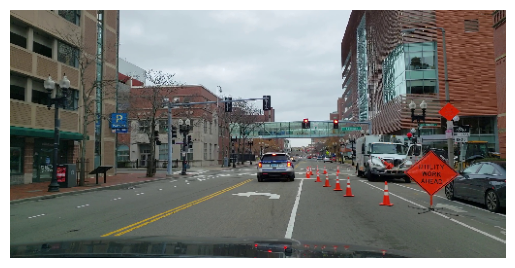

In [18]:
i=10
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [19]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

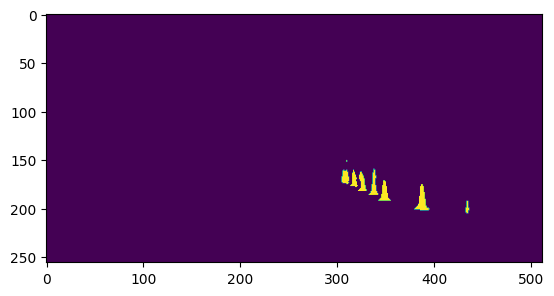

In [20]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

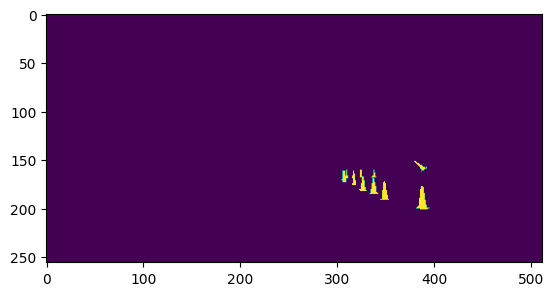

In [21]:
plt.imshow(val_targets[i])

### ******************************************************************************** ####

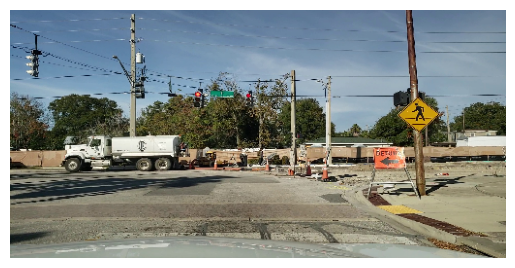

In [22]:
i=0
test_image = test_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [23]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

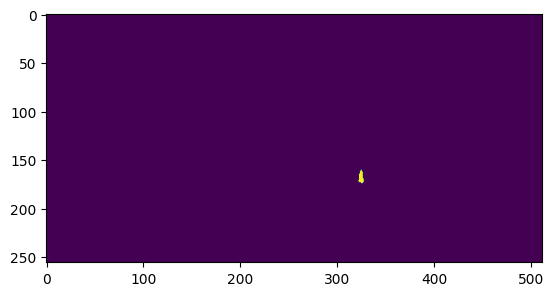

In [24]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

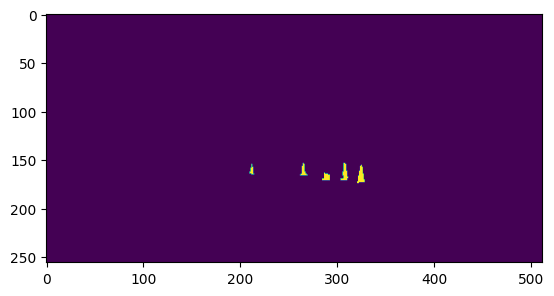

In [25]:
plt.imshow(test_targets[i])

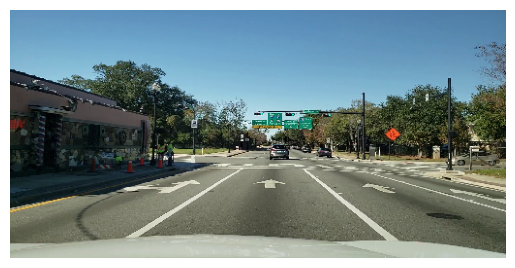

In [26]:
i=5
test_image = test_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [27]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

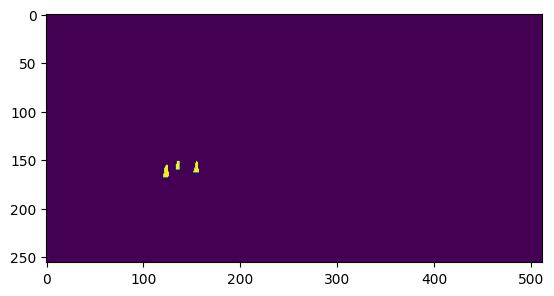

In [28]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

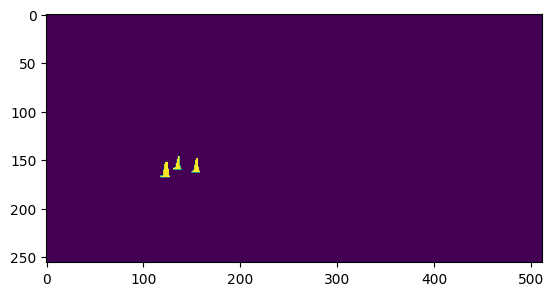

In [29]:
plt.imshow(test_targets[i])